In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["lines.linewidth"] = 1

In [8]:
from sklearn.metrics import r2_score, mean_absolute_error

# Define a function to score model based on R2 and MAE
def score(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Computes and prints the R2 and Mean Absolute Error scores for the model.

    Parameters:
    - y_true: The actual values of the data
    - y_pred: The predicted values from the model

    Returns:
    - None
    """
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"R2: {r2:,.5f}, MAE: {mae:,.5f}")

In [9]:
# Define the ticker, start, and end date for data download
ticker = "DBC"
start = "2007-01-01"
end = "2023-09-06"

# Download historical "Adjusted Close" prices using Yahoo Finance API
data = yf.download(ticker, start, end)[["Adj Close"]]

# Rename the column to indicate it contains actual prices for DBC
data.columns = [f"{ticker}_actual"]

# Display the first 5 rows of the DataFrame
data.tail()

[*********************100%***********************]  1 of 1 completed


,DBC_actual
Date,
2023-08-29,24.459999
2023-08-30,24.490000
2023-08-31,24.590000
2023-09-01,24.879999
2023-09-05,25.000000


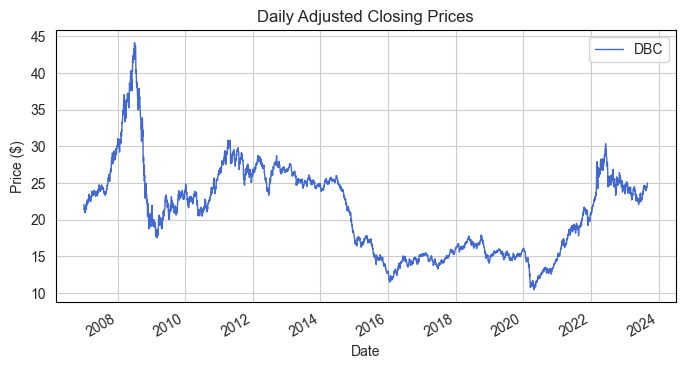

In [10]:
data.plot(figsize=(8, 4), title="Daily Adjusted Closing Prices", color="#4169D1")
plt.legend([f"{ticker}"])
plt.ylabel("Price ($)")
plt.show()

In [11]:
# Define the proportion of data to be used for training
train_size = 0.8

# Calculate the index where the data should be split between training and testing
slice_idx = int(len(data) * train_size)

# Split the DataFrame into training and testing sets
train_set, test_set = data[:slice_idx], data[slice_idx:]

# Display the shapes of the training and testing sets for verification
train_set.shape, test_set.shape


((3357, 1), (840, 1))

In [12]:
# Import MinMaxScaler from scikit-learn for data normalization
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
mm_scaler = MinMaxScaler()

# Fit and transform the training set to scale it between 0 and 1
scaled_train_set = mm_scaler.fit_transform(train_set)

# Transform the test set using the same scaler -this avoids data leakage
scaled_test_set = mm_scaler.transform(test_set)

# Output the shapes of the scaled training and test sets for verification
scaled_train_set.shape, scaled_test_set.shape


((3357, 1), (840, 1))

In [13]:
# Set the length of the sequence (lookback window)
seq_len = 50

# Determine the number of features in the training set
n_features = scaled_train_set.shape[1]

# Calculate the number of samples in the training and testing sets, after accounting for the sequence length
train_n_samples = len(scaled_train_set[seq_len:])
test_n_samples = len(scaled_test_set[seq_len:])

# Initialize arrays for training and testing data with zeros
X_train = np.zeros((train_n_samples, seq_len, n_features))
y_train = scaled_train_set[seq_len:].squeeze()

X_test = np.zeros((test_n_samples, seq_len, n_features))
y_test = scaled_test_set[seq_len:].squeeze()

# Populate the training data array (X_train) with sequences from scaled_train_set
# Each sequence is of length `seq_len` and starts at a different index
# The target (y_train) is the point immediately following the sequence
for i in range(seq_len, train_n_samples + seq_len):
    X_train[i - seq_len] = scaled_train_set[i-seq_len:i]

for i in range(seq_len, test_n_samples + seq_len):
    X_test[i - seq_len] = scaled_test_set[i-seq_len:i]

# Output the shapes of the prepared arrays for verification
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3307, 50, 1), (790, 50, 1), (3307,), (790,))

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Initializing the LSTM model with a name
lstm_model = Sequential(name="LSTM_1_day_forecast")

# Adding the first LSTM layer with 128 units and tanh activation; it returns sequences to the next layer
lstm_model.add(LSTM(128, activation="tanh", return_sequences=True, input_shape=X_train.shape[1:]))

# Adding the second LSTM layer with 64 units; it doesn't return sequences
lstm_model.add(LSTM(64, return_sequences=False))

# Adding a Dense layer with 32 units
lstm_model.add(Dense(32))

# Adding the output layer with 1 unit
lstm_model.add(Dense(1))

# Compiling the model with the Adam optimizer and mean absolute error as the loss function
lstm_model.compile(optimizer="adam", loss="mean_absolute_error")

# Fitting the model to the training data with a batch size of 10, 2 epochs, and a validation split of 0.2
lstm_model.fit(X_train, y_train, epochs=2, batch_size=10, validation_split=.2);

Epoch 1/2
265/265 [==============================] - 16s 44ms/step - loss: 0.0234 - val_loss: 0.0070
Epoch 2/2
265/265 [==============================] - 12s 45ms/step - loss: 0.0177 - val_loss: 0.0064


In [15]:
FC1D_scaled = lstm_model.predict(X_test)
FC1D = mm_scaler.inverse_transform(FC1D_scaled)

25/25 [==============================] - 1s 20ms/step


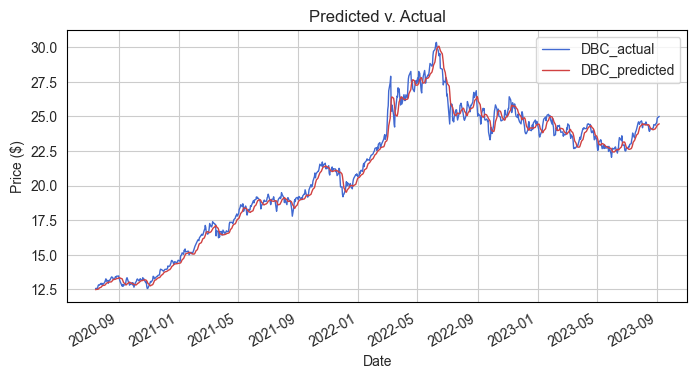

In [16]:
comparison_df = pd.DataFrame(index=test_set[seq_len:].index)
comparison_df[f"{ticker}_actual"] = test_set[seq_len:]
comparison_df[f"{ticker}_predicted"] = FC1D

comparison_df.plot(figsize=(8, 4), title="Predicted v. Actual", color=["#4169D1", "#D14141"])
plt.ylabel("Price ($)")
plt.show()

In [17]:
score(
    comparison_df[f"{ticker}_actual"].values, 
    comparison_df[f"{ticker}_predicted"].values
)

R2: 0.98759, MAE: 0.37995


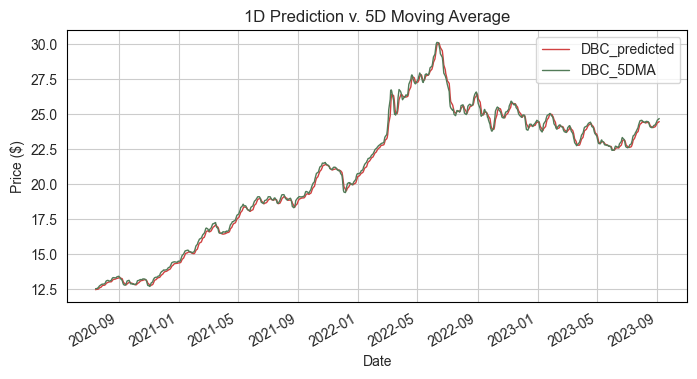

In [18]:
comparison_df[f"{ticker}_5DMA"] = test_set[seq_len-5:].rolling(5).mean()

comparison_df.drop(f"{ticker}_actual", axis=1).plot(
    figsize=(8, 4), 
    title="1D Prediction v. 5D Moving Average", 
    color=["#D14141", "#527B58"]
)

plt.ylabel("Price ($)")
plt.show()

In [19]:
# Set the length of the sequence (lookback window)
seq_len = 50

# Add a forecast parameter
forecast = 30

# Determine the number of features in the training set
n_features = scaled_train_set.shape[1]

# Calculate number of samples for training and testing sets
train_n_samples = len(scaled_train_set) - seq_len - forecast + 1
test_n_samples = len(scaled_test_set) - seq_len - forecast + 1

# Initialize training and testing data arrays
X_train = np.zeros((train_n_samples, seq_len, n_features))
y_train = np.zeros(train_n_samples)

X_test = np.zeros((test_n_samples, seq_len, n_features))
y_test = np.zeros(test_n_samples)

# Populate X_train and y_train
for i in range(train_n_samples):
    X_train[i] = scaled_train_set[i:i + seq_len]
    y_train[i] = scaled_train_set[i + seq_len + forecast - 1]

# Populate X_test and y_test
for i in range(test_n_samples):
    X_test[i] = scaled_test_set[i:i + seq_len]
    y_test[i] = scaled_test_set[i + seq_len + forecast - 1]

# Output the shapes of the prepared arrays for verification
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3278, 50, 1), (761, 50, 1), (3278,), (761,))

In [29]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Initializing the LSTM model with a name
lstm_model = Sequential(name="LSTM_Model")

# Adding the first LSTM layer with 128 units and tanh activation; it returns sequences to the next layer
lstm_model.add(LSTM(128, activation="tanh", return_sequences=True, input_shape=X_train.shape[1:]))

# Adding the second LSTM layer with 64 units; it doesn't return sequences
lstm_model.add(LSTM(64, return_sequences=False))

# Adding a Dense layer with 32 units
lstm_model.add(Dense(32))

# Adding the output layer with 1 unit
lstm_model.add(Dense(1))

# Compiling the model with the Adam optimizer and mean absolute error as the loss function
lstm_model.compile(optimizer="adam", loss="mean_absolute_error")

# Fitting the model to the training data with a batch size of 10, 2 epochs, and a validation split of 0.2
lstm_model.fit(X_train, y_train, epochs=2, batch_size=10, validation_split=.2);

Epoch 1/2
263/263 [==============================] - 16s 48ms/step - loss: 0.0498 - val_loss: 0.0282
Epoch 2/2
263/263 [==============================] - 12s 47ms/step - loss: 0.0439 - val_loss: 0.0238


In [21]:
FC30D_scaled = lstm_model.predict(X_test)
FC30D = mm_scaler.inverse_transform(FC30D_scaled)

24/24 [==============================] - 1s 19ms/step


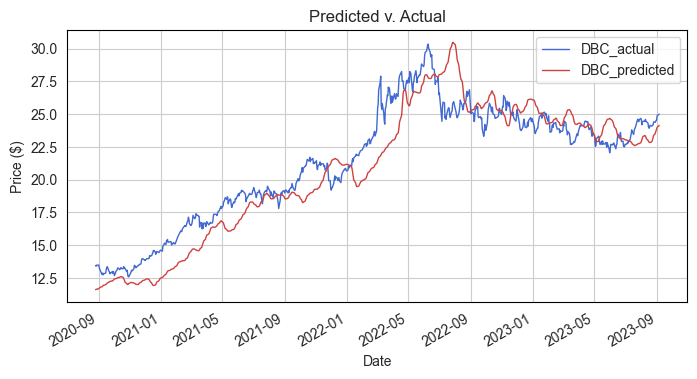

In [25]:
comparison_df = pd.DataFrame(index=test_set[seq_len+forecast-1:].index)
comparison_df[f"{ticker}_actual"] = test_set[seq_len+forecast-1:]
comparison_df[f"{ticker}_predicted"] = FC30D

comparison_df.plot(figsize=(8, 4), title="Predicted v. Actual", color=["#4169D1", "#D14141"])
plt.ylabel("Price ($)")
plt.show()

In [23]:
score(
    comparison_df[f"{ticker}_actual"].values, 
    comparison_df[f"{ticker}_predicted"].values
)

R2: 0.83644, MAE: 1.43676


In [30]:
lstm_model.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50, 128)           66560     
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________
